In [1]:
%matplotlib inline

from IPython.core.display import display, HTML
from scipy import stats
import pandas as pd
import numpy as np
from datetime import datetime as dt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.datasets import *

import tensorflow as tf
from tensorflow.contrib import keras
from tensorflow.contrib.keras import backend as K

import matplotlib.pyplot as plt
import functools
import pickle

N_FACTORS=5

/Users/natsu/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# 0: Prepare ML Classes

In [2]:
class VAE(object):
    def __init__(self, input_dim, hidden_layers,latent_dim, activation_func=None, use_bias=False, 
                 epsilon_mean=0., epsilon_std=1e-4,
                batch_size=64):
        self.input_dim = input_dim
        self.hidden_layers = hidden_layers
        self.latent_dim = latent_dim
        self.activation_func = activation_func
        self.use_bias = use_bias
        self.epsilon_mean = epsilon_mean
        self.epsilon_std = epsilon_std
        self.batch_size = batch_size
        self.vae = None
        self.encoder = None
        self.decoder = None
        
    def _sampling(self, args):
        mean, log_sigma = args
        epsilon = K.random_normal(shape=(self.batch_size, self.latent_dim), 
                                  mean=self.epsilon_mean, stddev=self.epsilon_std)
        return mean + K.exp(log_sigma)*epsilon
    
    
    
    def build(self):
        print("building VAE with input=%s, hidden_layers=%s"%(str(self.input_dim), str(self.hidden_layers)))
        _encoder_outputs = []
        _decoder_outputs = []
        _generator_outputs = []
        # Input
        x = keras.layers.Input(batch_shape=(self.batch_size, self.input_dim))
        _encoder_outputs.append(x)
        # Hidden
        for h_unit in self.hidden_layers:
            _h = keras.layers.Dense(h_unit,activation=self.activation_func, use_bias=self.use_bias)(_encoder_outputs[-1])
            _encoder_outputs.append(_h)
        # Mu / Sigma
        z_mean = keras.layers.Dense(self.latent_dim, activation=self.activation_func, use_bias=self.use_bias)(_encoder_outputs[-1])
        z_logsigma = keras.layers.Dense(self.latent_dim, activation=self.activation_func, use_bias=self.use_bias)(_encoder_outputs[-1])  
        z = keras.layers.Lambda(self._sampling)([z_mean, z_logsigma])
        _decoder_outputs.append(z)
        # Generator Input
        x_generator = keras.layers.Input(shape=(self.latent_dim,))
        _generator_outputs.append(x_generator)
        # Hidden
        for h_unit in reversed(self.hidden_layers):
            _h = keras.layers.Dense(h_unit,activation=self.activation_func, use_bias=self.use_bias)
            _decoder_outputs.append(_h(_decoder_outputs[-1]))
            _generator_outputs.append(_h(_generator_outputs[-1]))
        # Output
        o = keras.layers.Dense(self.input_dim,activation=self.activation_func, use_bias=self.use_bias)
        x_decoded_mean = o(_decoder_outputs[-1])
        x_generated = o(_generator_outputs[-1])
        # Model
        def _vae_loss(x, x_decoded_mean):
            xent_loss = keras.losses.binary_crossentropy(x, x_decoded_mean)
            kl_loss = -0.5 * K.mean(1 + z_logsigma - K.square(z_mean) - K.exp(z_logsigma), axis=1)
            return xent_loss + kl_loss
        vae = keras.models.Model(x, x_decoded_mean)
        encoder = keras.models.Model(x, z_mean)
        generator = keras.models.Model(x_generator, x_generated)
        #decoder = keras.models.Model(z_mean, x_decoded_mean)
        vae.compile(optimizer="adadelta", loss=_vae_loss)
        self.vae = vae
        self.encoder = encoder
        self.decoder = generator
        return self
    
    def fit(self, x_train, x_valid, epochs=100):
        x_train = x_train[: x_train.shape[0]- x_train.shape[0]%self.batch_size]
        x_valid = x_valid[: x_valid.shape[0]- x_valid.shape[0]%self.batch_size]
        s_cb = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
        self.vae.fit(x_train, x_train, shuffle=True, epochs=epochs, batch_size=self.batch_size, 
                    validation_data=(x_valid, x_valid), callbacks=[s_cb])
        
    def transform(self, x_test):
        return self.batch_mode(x_test, self.encoder.predict)
    
    def inverse_transform(self, x_encoded):
        return self.batch_mode(x_encoded, self.decoder.predict)
    
    def reconstruct(self, x_test):
        return self.batch_mode(x_test, self.vae.predict)
    
    def batch_mode(self, x_test, f):
        _n_data = x_test.shape[0]
        if _n_data % self.batch_size != 0:
            _n = self.batch_size - _n_data % self.batch_size
            x_test_added = np.concatenate((x_test, x_test[:self.batch_size - _n_data % self.batch_size]), axis=0)
        print(x_test_added.shape)
        _results = f(x_test_added,batch_size=self.batch_size)
        return _results[:_n_data]


Test Our VAE with MNIST

In [3]:
# Instantialization
vae_linear = VAE(input_dim=784, hidden_layers=[300, 300, 100, 100], 
          activation_func="linear", use_bias=False, epsilon_std=1e-4,latent_dim=10)
vae_linear.build()

vae_nonlinear = VAE(input_dim=784, hidden_layers=[300, 300, 100, 100], 
          activation_func="relu", use_bias=True, epsilon_std=1e-4,latent_dim=10)
vae_nonlinear.build()
# Download mnist
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Train
vae_linear.fit(x_train, x_train, 20)
vae_nonlinear.fit(x_train, x_train, 20)

building VAE with input=784, hidden_layers=[300, 300, 100, 100]
building VAE with input=784, hidden_layers=[300, 300, 100, 100]
Train on 59968 samples, validate on 59968 samples
Epoch 1/20
59968/59968 [==============================] - 35s 584us/step - loss: 0.3922 - val_loss: 0.2670
Epoch 2/20
59968/59968 [==============================] - 27s 447us/step - loss: 0.2630 - val_loss: 0.2210
Epoch 3/20
59968/59968 [==============================] - 27s 450us/step - loss: 0.2536 - val_loss: 0.2123
Epoch 4/20
59968/59968 [==============================] - 26s 431us/step - loss: 0.2901 - val_loss: 0.2102
Epoch 5/20
59968/59968 [==============================] - 25s 421us/step - loss: 0.2418 - val_loss: 0.1982
Epoch 6/20
59968/59968 [==============================] - 26s 429us/step - loss: 0.2239 - val_loss: 0.1868
Epoch 7/20
59968/59968 [==============================] - 28s 463us/step - loss: 0.2094 - val_loss: 0.1817
Epoch 8/20
59968/59968 [==============================] - 33s 552us/step 

(10048, 784)


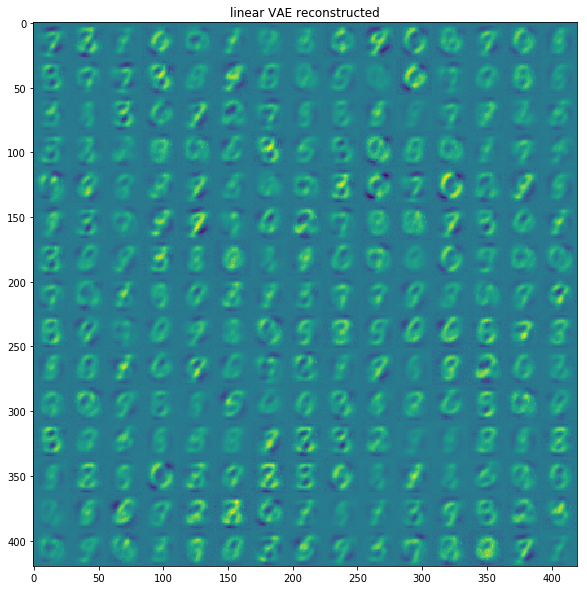

(10048, 784)


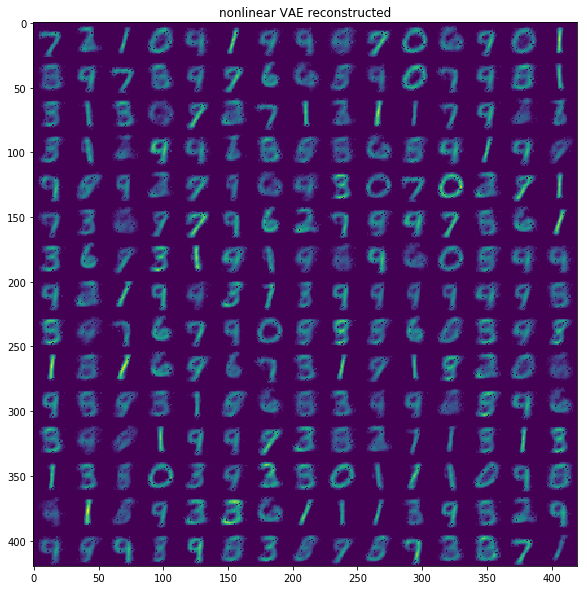

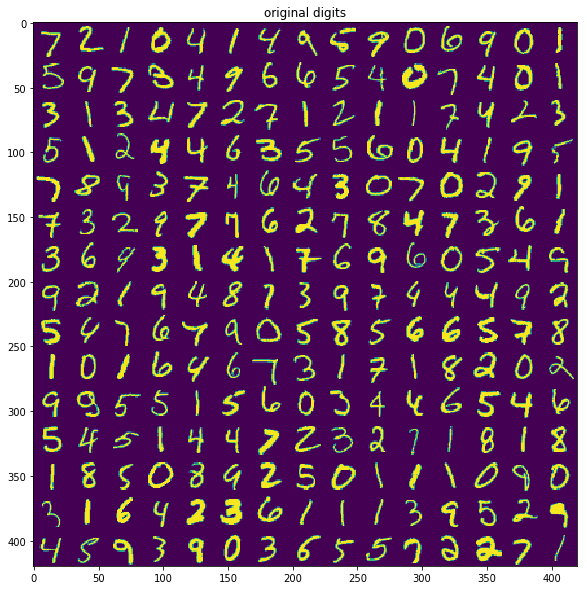

In [4]:

# Display a 2D manifold of the digits
n = 15  # figure with 15x15 digits
digit_size = 28
grid_x = np.linspace(-15, 15, n)
grid_y = np.linspace(-15, 15, n)

figure = np.zeros((digit_size * n, digit_size * n))
x_test_reconst = vae_linear.reconstruct(x_test)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = x_test_reconst[i*15+j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('linear VAE reconstructed')
plt.imshow(figure)
plt.show()

figure = np.zeros((digit_size * n, digit_size * n))
x_test_reconst = vae_nonlinear.reconstruct(x_test)
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = x_test_reconst[i*15+j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('nonlinear VAE reconstructed')
plt.imshow(figure)
plt.show()

figure = np.zeros((digit_size * n, digit_size * n))
for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        digit = x_test[i*15+j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.title('original digits')
plt.imshow(figure)
plt.show()

# Prepare Data
Timeline alignment(done), Return of 51 names, gap filling, filter out overnight / auction time buckets

In [5]:
data_origin = pd.read_csv("close_hk.csv").set_index("Unnamed: 0")
for c in data_origin.columns:
    if "close" in c:
        data_origin[c] = data_origin[c] -1
data_cols = [  c for c in data_origin.columns if "close" in c ]

for c in data_cols:
    data_origin[c] = data_origin[c].shift(-12) / data_origin[c] - 1

In [6]:
# Gap filling - use foward filling
data_origin = data_origin.ffill()

In [7]:
# filter out overnight / auction time buckets
data_origin['date']= [str(t).split("T")[0] for t in data_origin.index.values] 
data_origin['time']= [str(t).split("T")[1] for t in data_origin.index.values] 
data_origin = data_origin[data_origin['time']> '01:30:00.000'] # Remove open auction 
data_origin = data_origin[data_origin['time']!='07:00:00.000'] # Remove close auction 
data_origin = data_origin[data_origin['time']< '07:00:00.000'] # Remove overnight

In [8]:
#Remove nulls
data_origin = data_origin[~data_origin.isnull().any(axis=1)]

# Split Data
50% / 25% / 25% without overlap, check normality

In [9]:
data_train = data_origin.iloc[:int(data_origin.shape[0]/2)][data_cols]
data_valid = data_origin.iloc[int(data_origin.shape[0]/2):int(data_origin.shape[0]*3/4)][data_cols]
data_test  = data_origin.iloc[int(data_origin.shape[0]*3/4):][data_cols]

In [10]:
print("Train Set Normality Test")
for c in data_cols:
    _stats = stats.jarque_bera(data_train[c])
    if np.abs(_stats[1] > 0.01): print("%s,%s"%(c, _stats))
print("Valid Set Normality Test")
for c in data_cols:
    _stats = stats.jarque_bera(data_valid[c])
    if np.abs(_stats[1] > 0.01): print("%s,%s"%(c, _stats))
print("Test  Set Normality Test")
for c in data_cols:
    _stats = stats.jarque_bera(data_test[c])
    if np.abs(_stats[1] > 0.01): print("%s,%s"%(c, _stats))

Train Set Normality Test
Valid Set Normality Test
close-0001.HK,(2.1481750498212047, 0.34160932312809555)
close-0857.HK,(4.637475587038744, 0.09839770547696114)
close-1928.HK,(6.163180176298237, 0.04588623545016124)
Test  Set Normality Test
close-0011.HK,(1.5136320646723238, 0.46915783482815754)
close-0083.HK,(6.249342009393319, 0.04395139104629442)
close-0386.HK,(0.07762786725849848, 0.9619296752596558)
close-0883.HK,(0.03248964530800116, 0.9838864128838846)
close-1928.HK,(1.6299724477465558, 0.44264542525881967)
close-2628.HK,(6.8263428358432705, 0.03293657890775126)
close-3328.HK,(0.210986153770102, 0.8998807028027639)
close-3988.HK,(0.39744489306304304, 0.8197773938187253)


# Pipelines
PCA, VAE (+PCA), AE (+PCA)

PCA

In [11]:
model0 = PCA(n_components=N_FACTORS)
model0.fit(data_train)

data_test_encoded = model0.transform(data_test)
data_test_reconst = model0.inverse_transform(data_test_encoded)

error_p0 = mean_squared_error(data_test_reconst, data_test)
cov0 = pd.DataFrame(data_test_encoded).cov()
corr0= pd.DataFrame(data_test_encoded).corr()
print(cov0)
print(corr0)

          0         1         2         3         4
0  0.000736  0.000082 -0.000081 -0.000002  0.000083
1  0.000082  0.000086 -0.000035 -0.000005  0.000016
2 -0.000081 -0.000035  0.000088 -0.000004 -0.000013
3 -0.000002 -0.000005 -0.000004  0.000057 -0.000003
4  0.000083  0.000016 -0.000013 -0.000003  0.000050
          0         1         2         3         4
0  1.000000  0.325247 -0.316423 -0.011427  0.433273
1  0.325247  1.000000 -0.398262 -0.076090  0.243308
2 -0.316423 -0.398262  1.000000 -0.063183 -0.196762
3 -0.011427 -0.076090 -0.063183  1.000000 -0.060619
4  0.433273  0.243308 -0.196762 -0.060619  1.000000


In [12]:
model1 =  VAE(input_dim=50, hidden_layers=[100], 
          activation_func="linear", use_bias=False, epsilon_std=1e-4,latent_dim=N_FACTORS).build()
model1.fit(data_train, data_valid)

data_test_encoded1 = model1.transform(data_test)
data_test_reconst1 = model1.inverse_transform(data_test_encoded1)

error_p1 = mean_squared_error(data_test_reconst1, data_test)
cov1 = pd.DataFrame(data_test_encoded1).cov()
corr1= pd.DataFrame(data_test_encoded1).corr()
print(cov1)
print(corr1)

building VAE with input=50, hidden_layers=[100]
Train on 2240 samples, validate on 1088 samples
Epoch 1/100
2240/2240 [==============================] - 1s 325us/step - loss: -8.2524e-04 - val_loss: -0.0028
Epoch 2/100
2240/2240 [==============================] - 0s 54us/step - loss: -0.0042 - val_loss: -0.0065
Epoch 3/100
2240/2240 [==============================] - 0s 51us/step - loss: -0.0065 - val_loss: -0.0091
Epoch 4/100
2240/2240 [==============================] - 0s 54us/step - loss: -0.0076 - val_loss: -0.0104
Epoch 5/100
2240/2240 [==============================] - 0s 43us/step - loss: -0.0083 - val_loss: -0.0115
Epoch 6/100
2240/2240 [==============================] - 0s 58us/step - loss: -0.0093 - val_loss: -0.0132
Epoch 7/100
2240/2240 [==============================] - 0s 46us/step - loss: -0.0100 - val_loss: -0.0138
Epoch 8/100
2240/2240 [==============================] - 0s 39us/step - loss: -0.0103 - val_loss: -0.0141
Epoch 9/100
2240/2240 [============================

In [13]:
model2_a =  VAE(input_dim=50, hidden_layers=[100], 
          activation_func="linear", use_bias=False, epsilon_std=1e-4,latent_dim=N_FACTORS).build()
model2_b = PCA(n_components=N_FACTORS)

model2_a.fit(data_train, data_valid)
data_train_encoded = model2_a.transform(data_train)
model2_b.fit(data_train_encoded)

data_test_encoded2 = model2_b.transform( model2_a.transform(data_test) )
data_test_reconst2 = model2_a.inverse_transform( model2_b.inverse_transform(data_test_encoded2) )

error_p2 = mean_squared_error(data_test_reconst2, data_test)
cov2 = pd.DataFrame(data_test_encoded2).cov()
corr2= pd.DataFrame(data_test_encoded2).corr()
print(cov2)
print(corr2)

building VAE with input=50, hidden_layers=[100]
Train on 2240 samples, validate on 1088 samples
Epoch 1/100
2240/2240 [==============================] - 1s 332us/step - loss: -0.0015 - val_loss: -0.0046
Epoch 2/100
2240/2240 [==============================] - 0s 43us/step - loss: -0.0040 - val_loss: -0.0072
Epoch 3/100
2240/2240 [==============================] - 0s 42us/step - loss: -0.0054 - val_loss: -0.0086
Epoch 4/100
2240/2240 [==============================] - 0s 43us/step - loss: -0.0064 - val_loss: -0.0099
Epoch 5/100
2240/2240 [==============================] - 0s 47us/step - loss: -0.0072 - val_loss: -0.0110
Epoch 6/100
2240/2240 [==============================] - 0s 50us/step - loss: -0.0079 - val_loss: -0.0114
Epoch 7/100
2240/2240 [==============================] - 0s 48us/step - loss: -0.0082 - val_loss: -0.0116
Epoch 8/100
2240/2240 [==============================] - 0s 42us/step - loss: -0.0086 - val_loss: -0.0121
Epoch 9/100
2240/2240 [==============================] 

In [14]:
model3_a =  VAE(input_dim=50, hidden_layers=[200, 150, 100], 
          activation_func="relu", use_bias=False, epsilon_std=1e-4,latent_dim=N_FACTORS).build()
model3_b = PCA(n_components=N_FACTORS)

model3_a.fit(data_train, data_valid)
data_train_encoded = model3_a.transform(data_train)
model3_b.fit(data_train_encoded)

data_test_encoded3 = model3_b.transform( model3_a.transform(data_test) )
data_test_reconst3 = model3_a.inverse_transform( model3_b.inverse_transform(data_test_encoded3) )

error_p3 = mean_squared_error(data_test_reconst3, data_test)
cov3 = pd.DataFrame(data_test_encoded3).cov()
corr3= pd.DataFrame(data_test_encoded3).corr()
print(cov3)
print(corr3)

building VAE with input=50, hidden_layers=[200, 150, 100]
Train on 2240 samples, validate on 1088 samples
Epoch 1/100
2240/2240 [==============================] - 1s 419us/step - loss: -0.0019 - val_loss: -0.0023
Epoch 2/100
2240/2240 [==============================] - 0s 82us/step - loss: -0.0037 - val_loss: -0.0043
Epoch 3/100
2240/2240 [==============================] - 0s 73us/step - loss: -0.0045 - val_loss: -0.0052
Epoch 4/100
2240/2240 [==============================] - 0s 81us/step - loss: -0.0051 - val_loss: -0.0059
Epoch 5/100
2240/2240 [==============================] - 0s 94us/step - loss: -0.0058 - val_loss: -0.0069
Epoch 6/100
2240/2240 [==============================] - 0s 87us/step - loss: -0.0063 - val_loss: -0.0075
Epoch 7/100
2240/2240 [==============================] - 0s 82us/step - loss: -0.0065 - val_loss: -0.0077
Epoch 8/100
2240/2240 [==============================] - 0s 79us/step - loss: -0.0066 - val_loss: -0.0078
Epoch 9/100
2240/2240 [======================

In [15]:
error_p0, error_p1, error_p2, error_p3

(2.0663081637854844e-05,
 2.4871081017381578e-05,
 2.4080150781464706e-05,
 3.8069104431413615e-05)

In [16]:
cov0,cov1,cov2,cov3

(          0         1         2         3         4
 0  0.000736  0.000082 -0.000081 -0.000002  0.000083
 1  0.000082  0.000086 -0.000035 -0.000005  0.000016
 2 -0.000081 -0.000035  0.000088 -0.000004 -0.000013
 3 -0.000002 -0.000005 -0.000004  0.000057 -0.000003
 4  0.000083  0.000016 -0.000013 -0.000003  0.000050,
           0         1         2         3         4
 0  0.000110  0.000107 -0.000055 -0.000093  0.000018
 1  0.000107  0.000180 -0.000101 -0.000150 -0.000009
 2 -0.000055 -0.000101  0.000099  0.000090  0.000009
 3 -0.000093 -0.000150  0.000090  0.000174  0.000012
 4  0.000018 -0.000009  0.000009  0.000012  0.000040,
           0         1         2         3         4
 0  0.000461  0.000066 -0.000052 -0.000027 -0.000019
 1  0.000066  0.000067 -0.000017  0.000004 -0.000011
 2 -0.000052 -0.000017  0.000042  0.000014  0.000005
 3 -0.000027  0.000004  0.000014  0.000054 -0.000002
 4 -0.000019 -0.000011  0.000005 -0.000002  0.000022,
               0             1             

In [20]:
np.linalg.norm(cov0,ord="fro"), np.linalg.norm(cov1,ord="fro"), np.linalg.norm(cov2,ord="fro"),np.linalg.norm(cov3,ord="fro")

(0.0007786539701081546,
 0.0004643164262648952,
 0.0004891826249043998,
 0.00017815214160737055)

In [18]:
corr0,corr1,corr2,corr3

(          0         1         2         3         4
 0  1.000000  0.325247 -0.316423 -0.011427  0.433273
 1  0.325247  1.000000 -0.398262 -0.076090  0.243308
 2 -0.316423 -0.398262  1.000000 -0.063183 -0.196762
 3 -0.011427 -0.076090 -0.063183  1.000000 -0.060619
 4  0.433273  0.243308 -0.196762 -0.060619  1.000000,
           0         1         2         3         4
 0  1.000000  0.758916 -0.526033 -0.672185  0.273256
 1  0.758916  1.000000 -0.759921 -0.845644 -0.111711
 2 -0.526033 -0.759921  1.000000  0.687773  0.140255
 3 -0.672185 -0.845644  0.687773  1.000000  0.146009
 4  0.273256 -0.111711  0.140255  0.146009  1.000000,
           0         1         2         3         4
 0  1.000000  0.374711 -0.372265 -0.172808 -0.185771
 1  0.374711  1.000000 -0.327892  0.068355 -0.284590
 2 -0.372265 -0.327892  1.000000  0.286618  0.173344
 3 -0.172808  0.068355  0.286618  1.000000 -0.057743
 4 -0.185771 -0.284590  0.173344 -0.057743  1.000000,
           0         1         2         3 

In [21]:
np.linalg.norm(corr0,ord="fro"), np.linalg.norm(corr1,ord="fro"), np.linalg.norm(corr2,ord="fro"), np.linalg.norm(corr3,ord="fro")

(2.515451796681445, 3.37587345452743, 2.510805507783263, 2.3363947188064627)